
# Exoplanet Habitability (HABI) — v2 Notebook ✅

This notebook implements a hackathon-ready, **interpretable** habitability pipeline:

- Real uncertainty handling (uses archive error bars where available)
- **Kopparapu** Teff-dependent Habitable Zone (conservative & optimistic)
- Energy via **stellar flux** *or* **tidal proxy**, plus **seasonal stability** from eccentricity
- Atmosphere retention via a simple **Jeans parameter** (N₂/O₂ scenario)
- Confidence-aware scoring with **hard veto** guardrails
- **Monte Carlo** probability of viable surface conditions (with albedo + greenhouse variability)
- Optional **stellar activity** hooks (GALEX UV, TESS flare)
- Logistic calibration fallback, ablations, radar/stacked plots, and an auto-generated **Model Card**

> **Input:** your NASA Exoplanet Archive CSV (raw dump with `# COLUMN` lines or a cleaned CSV).  
> **Output:** ranked tables, figures, and a model-card text file.


## 0) Config — set your paths and knobs here

In [1]:

# === CONFIG ===
RAW_CSV   = "PS_2025.09.20_07.51.51.csv"   # raw NASA dump (with '# COLUMN' metadata). Set to None if using CLEAN_CSV.
CLEAN_CSV = None                            # if you have a cleaned CSV already, set it here and RAW_CSV=None

# Optional external catalogs (leave as None to skip star-activity augmentation)
GALEX_CSV = None        # e.g., "galex_subset.csv" with columns: ra, dec, NUV_mag, FUV_mag (AB)
TESS_FLARE_CSV = None   # e.g., "tess_flare_rates.csv" with columns: ra, dec, flare_rate_per_day
TIC_CSV = None          # optional TIC extract for cross-IDs (not required)

# Outputs
OUT_CLEAN              = "exoplanets_clean.csv"
OUT_DICTIONARY         = "exoplanets_dictionary.csv"
OUT_HABI_TABLE         = "habi_scores_v2.csv"
OUT_TOP_HABI           = "top_habi_v2.csv"
OUT_TOP_PROB           = "top_probability_v2.csv"
OUT_INSIDE_HZ_HI       = "inside_hz_highscore_v2.csv"
OUT_OUTSIDE_HZ_HI      = "outside_hz_highscore_v2.csv"
OUT_MODEL_CARD         = "MODEL_CARD_HABI_v2.txt"

# Plot files (set to None to skip saving)
PLOT_SCATTER           = "v2_insolation_vs_teff.png"
PLOT_HABI_HIST         = "v2_habi_hist.png"
PLOT_PROB_HIST         = "v2_prob_hist.png"
PLOT_CATEGORIES        = "v2_habi_bands.png"
PLOT_STACKEDTOP        = "v2_stacked_contrib_top10.png"
PLOT_RADAR_TOP3        = "v2_radar_top3.png"
PLOT_ABLATION          = "v2_ablation_deltas.png"
PLOT_CALIB_RELIAB      = "v2_calibration_curve.png"

# Ranking knobs
FIXED_HIGHSCORE_THRESHOLD = 0.60
MIN_CONF_FOR_RANK         = 0.60         # require this HABI_confidence for top lists
USE_CONF_PENALTY_SOFT     = True         # HABI_penalized_soft = HABI_hybrid*(0.5 + 0.5*confidence)

# Monte Carlo knobs
N_SAMPLES = 500          # increase if you have time (1000+ is nicer)
PRIOR_ECC_MEAN = 0.10
PRIOR_ECC_STD  = 0.05
DEFAULT_FRAC_ERR = {
    "st_teff": 0.05, "st_rad": 0.05, "pl_orbsmax": 0.08, "pl_rade": 0.06, "pl_orbeccen_abs": 0.05
}
ALBEDO_BETA = (2, 5)     # Beta(2,5) prior centered near ~0.29
GREENHOUSE_K_MEAN = 0.0  # K (Kelvin) offset mean
GREENHOUSE_K_SIG  = 20.0 # sigma (Kelvin) for greenhouse "noise"


## 1) Imports & constants

In [2]:

import re, math, warnings, sys
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np, random
np.random.seed(42); random.seed(42)

plt.rcParams.update({"figure.dpi": 150})

# Physical constants
G   = 6.67430e-11
M_E = 5.972e24
R_E = 6.371e6
kB  = 1.380649e-23
m_p = 1.6726219e-27
m_N2 = 28.0*m_p
T_SUN = 5778.0
R_E_over_R_SUN = 0.0091577  # Earth radii to solar radii


## 2) Load data & build data dictionary from `# COLUMN` lines

In [3]:

def _find_header_index(lines: List[str]) -> int:
    for i, line in enumerate(lines):
        if line.strip().startswith("pl_name"):
            return i
    for i, line in enumerate(lines):
        if "," in line and ("pl_name" in line) and ("hostname" in line):
            return i
    raise ValueError("Could not find header row (no 'pl_name' line).")

def _extract_column_descriptions(lines: List[str]) -> Dict[str,str]:
    desc = {}
    for line in lines:
        s = line.strip().lstrip("#").strip()
        if s.startswith("COLUMN "):
            try:
                after = s[len("COLUMN "):]
                name, d = after.split(":", 1)
                desc[name.strip()] = " ".join(d.strip().split())
            except Exception:
                pass
    return desc

def load_exoplanets(RAW_CSV=None, CLEAN_CSV=None):
    if CLEAN_CSV:
        with open(CLEAN_CSV, "r", encoding="utf-8") as f:
            lines = f.readlines()
        try:
            header_idx = _find_header_index(lines)
        except:
            header_idx = 0
        df = pd.read_csv(CLEAN_CSV, skiprows=header_idx, low_memory=False)
        df.columns = [c.strip() for c in df.columns]
        desc = _extract_column_descriptions(lines)
        dict_df = pd.DataFrame([{"column": c, "description": desc.get(c, "")} for c in df.columns])
        return df, dict_df
    if not RAW_CSV:
        raise ValueError("Provide RAW_CSV or CLEAN_CSV.")
    with open(RAW_CSV, "r", encoding="utf-8") as f:
        lines = f.readlines()
    header_idx = _find_header_index(lines)
    df = pd.read_csv(RAW_CSV, skiprows=header_idx, low_memory=False)
    df.columns = [c.strip() for c in df.columns]
    desc = _extract_column_descriptions(lines)
    dict_df = pd.DataFrame([{"column": c, "description": desc.get(c, "")} for c in df.columns])
    return df, dict_df

df, dict_df = load_exoplanets(RAW_CSV=RAW_CSV, CLEAN_CSV=CLEAN_CSV)
df.to_csv(OUT_CLEAN, index=False)
dict_df.to_csv(OUT_DICTIONARY, index=False)
print(f"Loaded rows={len(df):,}, cols={len(df.columns)}")

num_cols = [
    "ra","dec",
    "pl_orbsmax","pl_orbper","pl_orbeccen","pl_rade","pl_bmasse","pl_eqt",
    "st_teff","st_rad","st_mass","st_met",
    "sy_dist","sy_vmag","sy_gaiamag","sy_pnum","disc_year"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


Loaded rows=38,898, cols=92


## 3) Kopparapu HZ edges (conservative & optimistic)

In [4]:

KOPP = {
    "RV":      (1.776000e+00, 2.136000e-04, 2.533000e-08, -1.33200e-11, -3.09700e-15),
    "RG_1ME":  (1.107000e+00, 1.332000e-04, 1.580000e-08, -8.30800e-12, -1.93100e-15),
    "MG":      (3.560000e-01, 6.171000e-05, 1.698000e-09, -3.19800e-12, -5.57500e-16),
    "EM":      (3.200000e-01, 5.547000e-05, 1.526000e-09, -2.87400e-12, -5.01100e-16),
    "RG_5ME":  (1.188000e+00, 1.433000e-04, 1.707000e-08, -8.96800e-12, -2.08400e-15),
    "RG_0p1ME":(9.900000e-01, 1.209000e-04, 1.404000e-08, -7.41800e-12, -1.71300e-15)
}

def kopparapu_seff(T_eff, kind="RG_1ME"):
    Seff_sun, a, b, c, d = KOPP[kind]
    Tstar = (T_eff - 5780.0)/1000.0
    return Seff_sun + a*Tstar + b*(Tstar**2) + c*(Tstar**3) + d*(Tstar**4)

def hz_edges_kopparapu(Teff, Rp_Re=None):
    if pd.isna(Teff):
        return {"conservative": (np.nan, np.nan), "optimistic": (np.nan, np.nan)}
    if (Rp_Re is not None) and (not pd.isna(Rp_Re)):
        inner = "RG_5ME" if Rp_Re>1.5 else "RG_0p1ME" if Rp_Re<0.7 else "RG_1ME"
    else:
        inner = "RG_1ME"
    return {
        "conservative": (kopparapu_seff(Teff, inner), kopparapu_seff(Teff, "MG")),
        "optimistic":   (kopparapu_seff(Teff, "RV"),   kopparapu_seff(Teff, "EM")),
    }


## 4) Astro basics: luminosity, insolation, seasonal flux extremes

In [5]:

def stellar_luminosity(row):
    r = row.get("st_rad", np.nan)
    t = row.get("st_teff", np.nan)
    if pd.isna(r) or pd.isna(t): return np.nan
    return (r**2.0) * ((t/T_SUN)**4.0)

df["st_lum"] = df.apply(stellar_luminosity, axis=1)

def insolation_from_La(L, a):
    if pd.isna(L) or pd.isna(a) or a <= 0: return np.nan
    return L / (a**2.0)

df["insolation_earth_units"] = df.apply(lambda r: insolation_from_La(r.get("st_lum", np.nan), r.get("pl_orbsmax", np.nan)), axis=1)

def seasonal_flux_extremes(L, a, e):
    if pd.isna(L) or pd.isna(a) or a<=0 or pd.isna(e): return (np.nan, np.nan)
    Smin = L / (a*(1.0+e))**2
    Smax = L / (a*(1.0-e))**2 if e<1 else np.nan
    return Smin, Smax

Smins, Smaxs = [], []
for _, r in df.iterrows():
    smin, smax = seasonal_flux_extremes(r.get("st_lum", np.nan), r.get("pl_orbsmax", np.nan), r.get("pl_orbeccen", np.nan))
    Smins.append(smin); Smaxs.append(smax)
df["Smin"], df["Smax"] = Smins, Smaxs


## 5) HZ flags (Kopparapu-based) + Earth-size label

In [6]:

cons_in, cons_out, opt_in, opt_out = [], [], [], []
for _, r in df.iterrows():
    edges = hz_edges_kopparapu(r.get("st_teff", np.nan), r.get("pl_rade", np.nan))
    ci, co = edges["conservative"]
    oi, oo = edges["optimistic"]
    cons_in.append(ci); cons_out.append(co); opt_in.append(oi); opt_out.append(oo)
df["Seff_inner_conservative"]  = cons_in
df["Seff_outer_conservative"]  = cons_out
df["Seff_inner_optimistic"]    = opt_in
df["Seff_outer_optimistic"]    = opt_out

def in_band(S, inner, outer):
    if pd.isna(S) or pd.isna(inner) or pd.isna(outer): return np.nan
    lo, hi = min(inner, outer), max(inner, outer)
    return (S>=lo) and (S<=hi)

df["is_hz_conservative"] = df.apply(lambda r: in_band(r["insolation_earth_units"], r["Seff_inner_conservative"], r["Seff_outer_conservative"]), axis=1)
df["is_hz_optimistic"]   = df.apply(lambda r: in_band(r["insolation_earth_units"], r["Seff_inner_optimistic"],   r["Seff_outer_optimistic"]),   axis=1)

df["is_earthsized"] = df["pl_rade"].between(0.8, 1.5, inclusive="both")
df["earthlike_flag"] = df["is_hz_conservative"] & df["is_earthsized"]


## 6) Sub-scores (Energy, Surface, Atmosphere, Stellar, Orbital, System, Feasibility)

In [7]:

def clip01(x): 
    try: return max(0.0, min(1.0, float(x)))
    except: return np.nan

def score_flux_closeness(S, inner, outer):
    if pd.isna(S) or pd.isna(inner) or pd.isna(outer): return np.nan
    lo, hi = min(inner, outer), max(inner, outer)
    if S<=0 or lo<=0 or hi<=0: return np.nan
    Sc = (lo*hi)**0.5
    d = abs(math.log(S/Sc))
    base = 1.0 - d/2.5
    if lo <= S <= hi: base = max(base, 0.9)
    return clip01(base)

def score_seasonal_stability(Smin, Smax, inner, outer):
    if any(pd.isna(x) for x in [Smin, Smax, inner, outer]): return np.nan
    lo, hi = min(inner, outer), max(inner, outer)
    inside_frac = float((Smin>=lo) and (Smax<=hi))
    span = (Smax - Smin)/max(Smax,1e-9)
    return clip01(0.7*inside_frac + 0.3*(1.0 - min(span,1.0)))

def score_tidal_proxy(e, a_AU, Rp_Re):
    if pd.isna(e) or pd.isna(a_AU): return np.nan
    e0, a0 = 0.2, 0.05
    proxy = (e**2 / max(a_AU,1e-3)**6) / (e0**2 / a0**6)
    proxy = min(proxy, 3.0)/3.0
    if not pd.isna(Rp_Re):
        proxy = 0.85*proxy + 0.15*clip01((Rp_Re-0.5)/2.5)
    return clip01(proxy)

def energy_subscore(row):
    S   = row.get("insolation_earth_units", np.nan)
    a   = row.get("pl_orbsmax", np.nan)
    e   = row.get("pl_orbeccen", np.nan)
    Rp  = row.get("pl_rade", np.nan)
    inner, outer = row.get("Seff_inner_conservative", np.nan), row.get("Seff_outer_conservative", np.nan)
    s_flux  = score_flux_closeness(S, inner, outer)
    s_tide  = score_tidal_proxy(e, a, Rp)
    s_energy_path = np.nanmax([v for v in [s_flux, s_tide] if not pd.isna(v)]) if not (pd.isna(s_flux) and pd.isna(s_tide)) else np.nan
    s_stab  = score_seasonal_stability(row.get("Smin", np.nan), row.get("Smax", np.nan), inner, outer)
    if pd.isna(s_energy_path) and pd.isna(s_stab): return np.nan
    if pd.isna(s_stab): return s_energy_path
    if pd.isna(s_energy_path): return 0.6*s_stab
    return clip01(0.75*s_energy_path + 0.25*s_stab)

def surface_subscore(Re, Me):
    if pd.isna(Re) and pd.isna(Me): return np.nan
    if not pd.isna(Re):
        if Re <= 1.1: s = 1.0
        elif Re <= 1.6: s = 0.85
        elif Re <= 2.0: s = 0.60
        elif Re <= 2.5: s = 0.40
        else: s = 0.10
    else:
        s = np.nan
    if not pd.isna(Me) and not pd.isna(Re):
        rho_rel = Me/(Re**3)
        if rho_rel >= 0.9: s = max(s, 0.8)
        if rho_rel >= 1.5: s = max(s, 0.95)
    return clip01(s if s==s else np.nan)

def escape_velocity(Me, Re):
    if pd.isna(Me) or pd.isna(Re) or Me<=0 or Re<=0: return np.nan
    M = Me*M_E; R = Re*R_E
    return math.sqrt(2*G*M/R)

def eq_temp_from_S(S, albedo=0.3, emiss=1.0):
    if pd.isna(S): return np.nan
    return 278.0 * (S**0.25) * ((1.0 - albedo)/(4.0*emiss))**0.25

def atmosphere_subscore(Me, Re, Teq, S):
    if pd.isna(Teq) and not pd.isna(S):
        Teq = eq_temp_from_S(S)
    vesc = escape_velocity(Me, Re)
    if pd.isna(vesc) or pd.isna(Teq): return np.nan
    lam = (m_N2 * vesc**2) / (2*kB*max(Teq,1.0))
    if lam <= 5: return 0.2
    if lam >= 20: return 1.0
    return 0.2 + 0.8*(lam-5)/(20-5)

def stellar_subscore(Teff):
    if pd.isna(Teff): return np.nan
    if 4400 <= Teff <= 6200: return 1.0
    if Teff < 4400: return clip01((Teff - 3200)/(4400-3200))
    return clip01((7000-Teff)/(7000-6200))

def orbital_subscore(P_days, e, a_AU):
    s = 1.0
    if not pd.isna(P_days):
        if P_days < 2: s *= 0.2
        elif P_days < 5: s *= 0.5
        elif P_days < 10: s *= 0.7
    if not pd.isna(e):
        if e > 0.4: s *= 0.3
        elif e > 0.2: s *= 0.7
    if not pd.isna(a_AU) and a_AU < 0.03: s *= 0.5
    return clip01(s)

def system_subscore(pnum):
    if pd.isna(pnum): return np.nan
    if pnum >= 5: return 1.0
    if pnum == 4: return 0.8
    if pnum == 3: return 0.6
    if pnum == 2: return 0.5
    return 0.4

def feasibility_subscore(dist_pc, vmag, Rp_Re, Rstar_Rsun):
    vals = []
    if not pd.isna(dist_pc):
        vals.append(1.0 if dist_pc<=50 else 0.8 if dist_pc<=100 else 0.6 if dist_pc<=300 else 0.3 if dist_pc<=1000 else 0.1)
    if not pd.isna(vmag):
        vals.append(1.0 if vmag<=8 else 0.8 if vmag<=10 else 0.6 if vmag<=12 else 0.4 if vmag<=14 else 0.2)
    if not pd.isna(Rp_Re) and not pd.isna(Rstar_Rsun) and Rstar_Rsun>0:
        Rp_Rs = (Rp_Re*R_E_over_R_SUN)/Rstar_Rsun
        depth = (Rp_Rs**2)
        if depth >= 1e-3: vals.append(1.0)
        elif depth >= 3e-4: vals.append(0.7)
        elif depth >= 1e-4: vals.append(0.4)
        else: vals.append(0.2)
    return np.mean(vals) if vals else np.nan

W = {"energy":0.25,"surface":0.20,"atmosphere":0.20,"stellar":0.15,"orbital":0.10,"system":0.05,"feasibility":0.05}

def compute_subscores(row):
    subs = {
        "energy":      energy_subscore(row),
        "surface":     surface_subscore(row.get("pl_rade", np.nan), row.get("pl_bmasse", np.nan)),
        "atmosphere":  atmosphere_subscore(row.get("pl_bmasse", np.nan), row.get("pl_rade", np.nan), row.get("pl_eqt", np.nan), row.get("insolation_earth_units", np.nan)),
        "stellar":     stellar_subscore(row.get("st_teff", np.nan)),
        "orbital":     orbital_subscore(row.get("pl_orbper", np.nan), row.get("pl_orbeccen", np.nan), row.get("pl_orbsmax", np.nan)),
        "system":      system_subscore(row.get("sy_pnum", np.nan)),
        "feasibility": feasibility_subscore(row.get("sy_dist", np.nan), row.get("sy_vmag", np.nan), row.get("pl_rade", np.nan), row.get("st_rad", np.nan)),
    }
    num=den=0.0
    for k,v in subs.items():
        if not pd.isna(v):
            num += v*W[k]
            den += W[k]
    habi = (num/den) if den>0 else np.nan
    conf = den/sum(W.values())
    return habi, conf, subs

## 6) Sub-scores — idempotent write (replace the old records/merge block only)

sub_names = ["energy","surface","atmosphere","stellar","orbital","system","feasibility"]

# Preallocate arrays to avoid extra DataFrames and merges
n = len(df)
HABI = np.full(n, np.nan, dtype="float32")
CONF = np.full(n, np.nan, dtype="float32")
SUBS = {f"sub_{k}": np.full(n, np.nan, dtype="float32") for k in sub_names}

# Compute once per row; write into arrays
for i, (_, row) in enumerate(df.iterrows()):
    h, conf, subs = compute_subscores(row)   # uses the functions you kept above
    HABI[i] = h if pd.notna(h) else np.nan
    CONF[i] = conf if pd.notna(conf) else np.nan
    for k in sub_names:
        v = subs.get(k, np.nan)
        SUBS[f"sub_{k}"][i] = v if pd.notna(v) else np.nan

# Assign (overwrite) — no merge, safe to re-run
df["HABI"] = HABI
df["HABI_confidence"] = CONF
for k in sub_names:
    df[f"sub_{k}"] = SUBS[f"sub_{k}"]


## 7) Hard vetoes, confidence-aware scoring, flags

In [8]:

def hard_veto_with_reason(row):
    S = row.get("insolation_earth_units", np.nan)
    a = row.get("pl_orbsmax", np.nan)
    Re= row.get("pl_rade", np.nan)
    if (not pd.isna(S)) and (not pd.isna(a)) and (S>10) and (a<0.02):
        return True, "Ultra-hot & ultra-close"
    if (not pd.isna(Re)) and (Re>8):
        return True, "Ultra-giant (gas) — surface out-of-scope"
    if (not pd.isna(Re)) and (Re<=0) or ((not pd.isna(a)) and (a<=0)):
        return True, "Non-physical parameter"
    return False, ""

veto_flags, veto_reasons = [], []
for _, rr in df.iterrows():
    v, why = hard_veto_with_reason(rr)
    veto_flags.append(v); veto_reasons.append(why)

df["HABI_veto"] = veto_flags
df["HABI_veto_reason"] = veto_reasons
df["HABI_hybrid"] = np.where(df["HABI_veto"], 0.0, df["HABI"])

if True:
    df["HABI_penalized_soft"] = df["HABI_hybrid"] * (0.5 + 0.5*df["HABI_confidence"])
else:
    df["HABI_penalized_soft"] = df["HABI_hybrid"]

THRESH = 0.60
df["high_score"]      = df["HABI_penalized_soft"] >= THRESH
df["inside_hz_high"]  = df["is_hz_conservative"] & df["high_score"]
df["outside_hz_high"] = (~df["is_hz_conservative"].fillna(False)) & df["high_score"]


## 8) Probability of viable surface conditions (Monte Carlo + calibrated fallback)

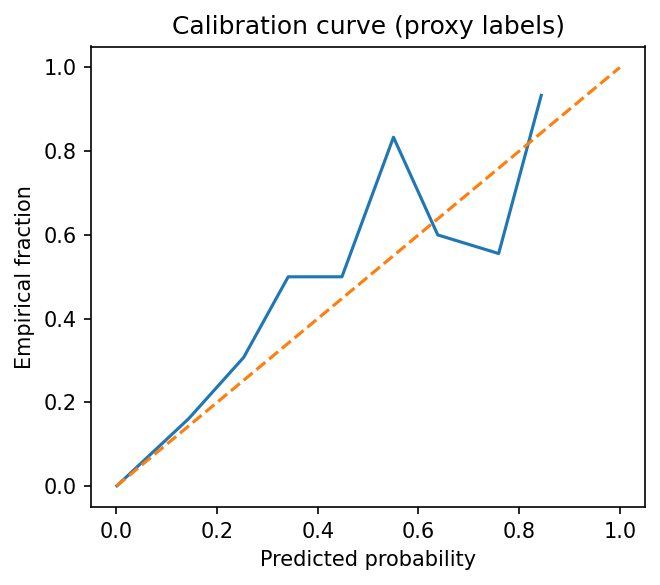

In [9]:

def find_err_cols(df, base):
    cands = [(f"{base}err1", f"{base}err2"), (f"{base}_err1", f"{base}_err2")]
    for pos, neg in cands:
        if pos in df.columns and neg in df.columns:
            return pos, neg
    return None, None

def sigma_from_errs(val, errp, errm):
    if pd.isna(val): return np.nan
    if pd.isna(errp) and pd.isna(errm): return np.nan
    e = np.nanmax([abs(errp) if not pd.isna(errp) else np.nan,
                   abs(errm) if not pd.isna(errm) else np.nan])
    if pd.isna(e): return np.nan
    return max(e/1.96, abs(val)*1e-6)

def draw_trunc_normal(val, sigma, n, lo=None, hi=None):
    if pd.isna(val) or pd.isna(sigma) or sigma<=0: return np.full(n, np.nan)
    x = np.random.normal(val, sigma, size=n)
    if lo is not None: x = np.maximum(x, lo)
    if hi is not None: x = np.minimum(x, hi)
    return x

def mc_probability_row(row, n=500):
    if (not pd.isna(row.get("pl_rade", np.nan))) and (row["pl_rade"]>8):
        return 0.0, "veto_giant"

    t_star = row.get("st_teff", np.nan)
    r_star = row.get("st_rad", np.nan)
    a_AU   = row.get("pl_orbsmax", np.nan)
    Rp     = row.get("pl_rade", np.nan)
    ecc    = row.get("pl_orbeccen", np.nan)

    teff_pos, teff_neg = find_err_cols(df, "st_teff")
    sig_teff = sigma_from_errs(t_star, row.get(teff_pos, np.nan), row.get(teff_neg, np.nan))
    if pd.isna(sig_teff) and not pd.isna(t_star): sig_teff = 0.05*abs(t_star)

    srad_pos, srad_neg = find_err_cols(df, "st_rad")
    sig_srad = sigma_from_errs(r_star, row.get(srad_pos, np.nan), row.get(srad_neg, np.nan))
    if pd.isna(sig_srad) and not pd.isna(r_star): sig_srad = 0.05*abs(r_star)

    a_pos, a_neg = find_err_cols(df, "pl_orbsmax")
    sig_a = sigma_from_errs(a_AU, row.get(a_pos, np.nan), row.get(a_neg, np.nan))
    if pd.isna(sig_a) and not pd.isna(a_AU): sig_a = 0.08*abs(a_AU)

    re_pos, re_neg = find_err_cols(df, "pl_rade")
    sig_Re = sigma_from_errs(Rp, row.get(re_pos, np.nan), row.get(re_neg, np.nan))
    if pd.isna(sig_Re) and not pd.isna(Rp): sig_Re = 0.06*abs(Rp)

    essentials = [t_star, r_star, a_AU, Rp, sig_teff, sig_srad, sig_a, sig_Re]
    if any(pd.isna(x) for x in essentials):
        return np.nan, "insufficient_data"

    T_s  = draw_trunc_normal(t_star, sig_teff, n, lo=2400, hi=10000)
    R_s  = draw_trunc_normal(r_star, sig_srad, n, lo=0.05, hi=50)
    a_s  = draw_trunc_normal(a_AU,  sig_a,    n, lo=0.005, hi=100)
    Re_s = draw_trunc_normal(Rp,     sig_Re,   n, lo=0.1,   hi=20)
    e_s  = np.clip(np.random.normal(0.10 if pd.isna(ecc) else ecc, 0.05, size=n), 0.0, 0.9)

    A_s  = np.random.beta(2,5, size=n)
    dT_g = np.random.normal(0.0, 20.0, size=n)

    L_s  = (R_s**2.0) * ((T_s/T_SUN)**4.0)
    S_s  = L_s / np.maximum(a_s**2.0, 1e-9)

    edges = hz_edges_kopparapu(t_star, Rp)
    ci, co = edges["conservative"]

    T_eq = 278.0*(S_s**0.25) * ((1.0 - A_s)/(4.0*1.0))**0.25 + dT_g

    cond_A = (S_s>=min(ci,co)) & (S_s<=max(ci,co)) & (Re_s<=1.6) & (T_s>=4400) & (T_s<=6200) & (a_s>=0.03) & (e_s<=0.4)
    cond_B = (S_s>=0.20) & (S_s<=2.0) & (Re_s<=2.5) & (a_s<0.20) & (e_s>=0.10)

    p = float(np.nanmean(cond_A | cond_B))
    return p, "monte_carlo"

p_list, how_list = [], []
for _, row in df.iterrows():
    p, how = mc_probability_row(row, n=500)
    p_list.append(p); how_list.append(how)
df["p_viable_mc"] = p_list
df["p_mc_method"] = how_list

try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.calibration import calibration_curve
    SK_OK = True
except Exception:
    SK_OK = False

y_proxy = (df["is_hz_optimistic"].fillna(False) & (df["pl_rade"]<1.8)).astype(float)
feat_cols = [c for c in [f"sub_{k}" for k in ["energy","surface","atmosphere","stellar","orbital","system","feasibility"]] if c in df.columns]
X = df[feat_cols].fillna(0.0)

if SK_OK and y_proxy.notna().sum() > 10:
    try:
        lr = LogisticRegression(max_iter=200)
        lr.fit(X.values, y_proxy.values)
        df["p_viable_habi"] = lr.predict_proba(X.values)[:,1]
        prob_true, prob_pred = calibration_curve(y_proxy.values, df["p_viable_habi"].values, n_bins=10, strategy="uniform")
        import matplotlib.pyplot as plt
        plt.figure(figsize=(4.5,4))
        plt.plot(prob_pred, prob_true)
        plt.plot([0,1],[0,1], linestyle="--")
        plt.xlabel("Predicted probability"); plt.ylabel("Empirical fraction")
        plt.title("Calibration curve (proxy labels)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        import warnings
        warnings.warn(f"Calibration failed: {e}")
        df["p_viable_habi"] = np.nan
else:
    def logistic(x): return 1/(1+np.exp(-x))
    H = df["HABI_hybrid"].copy()
    m  = np.nanmedian(H)
    h90 = np.nanpercentile(H.dropna(), 90) if H.notna().sum() else 0.8
    target_p90 = 0.85
    k  = (np.log(target_p90/(1-target_p90)) - np.log(0.5/0.5)) / max(h90 - m, 1e-6)
    df["p_viable_habi"] = logistic(k*(H - m))

df["p_viable_final"] = np.where(df["p_mc_method"].eq("monte_carlo"), df["p_viable_mc"], df["p_viable_habi"])


## 10) Plots (Matplotlib only; one figure per chart, no specific colors)

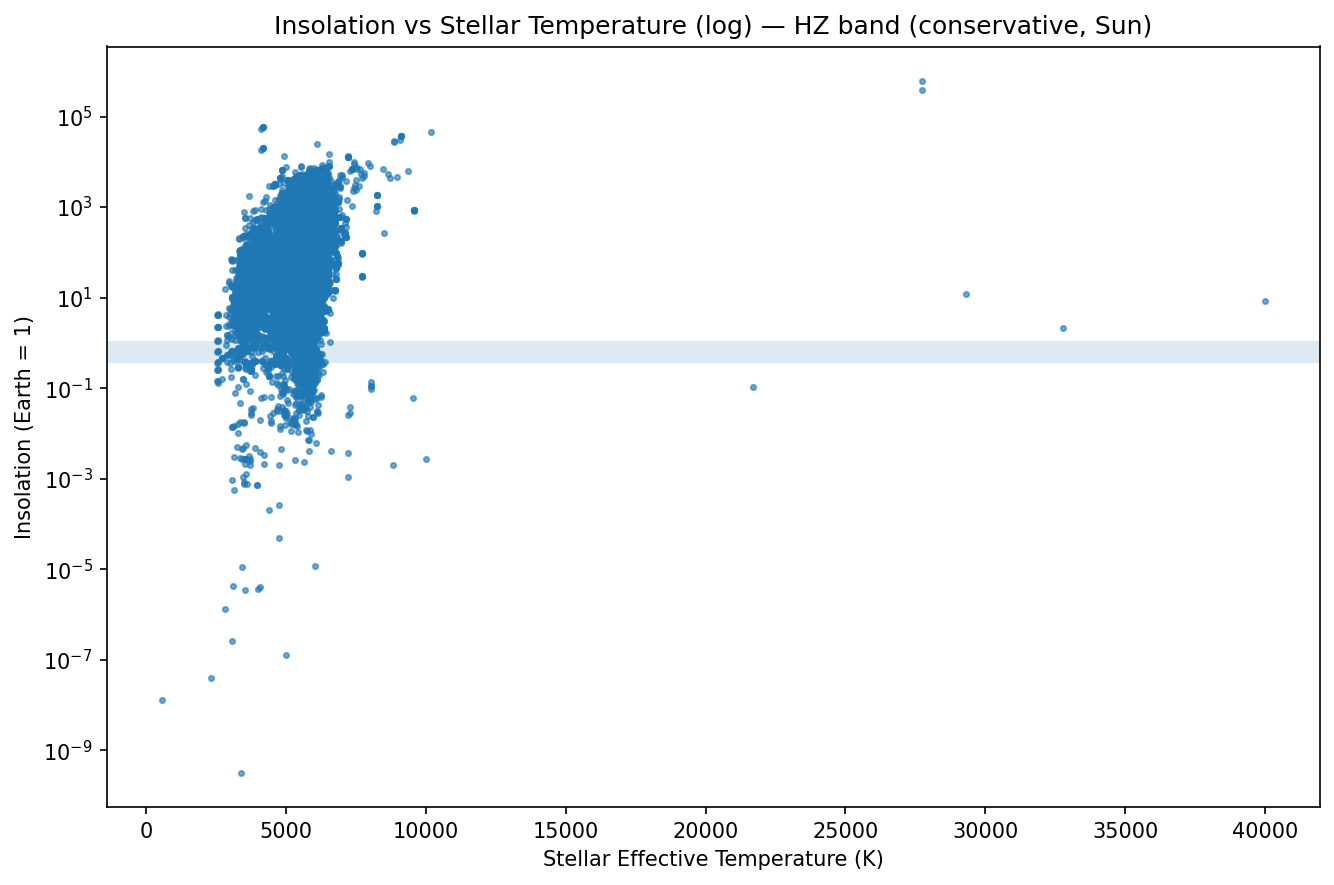

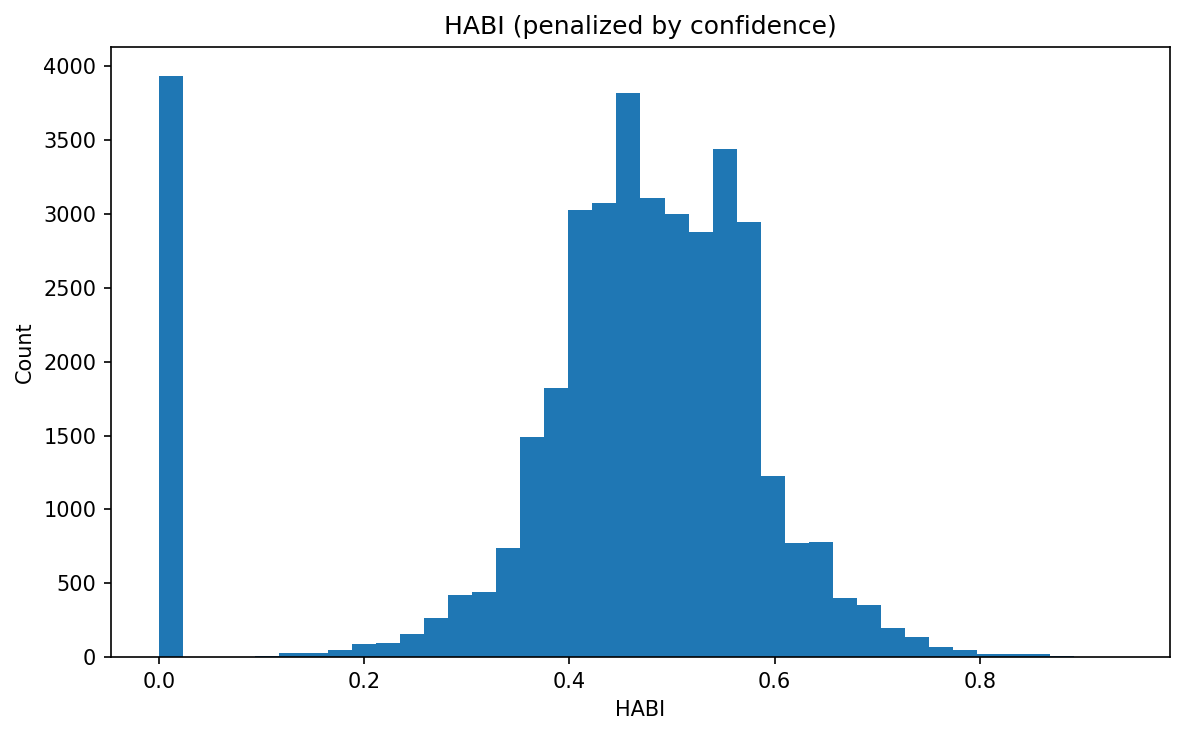

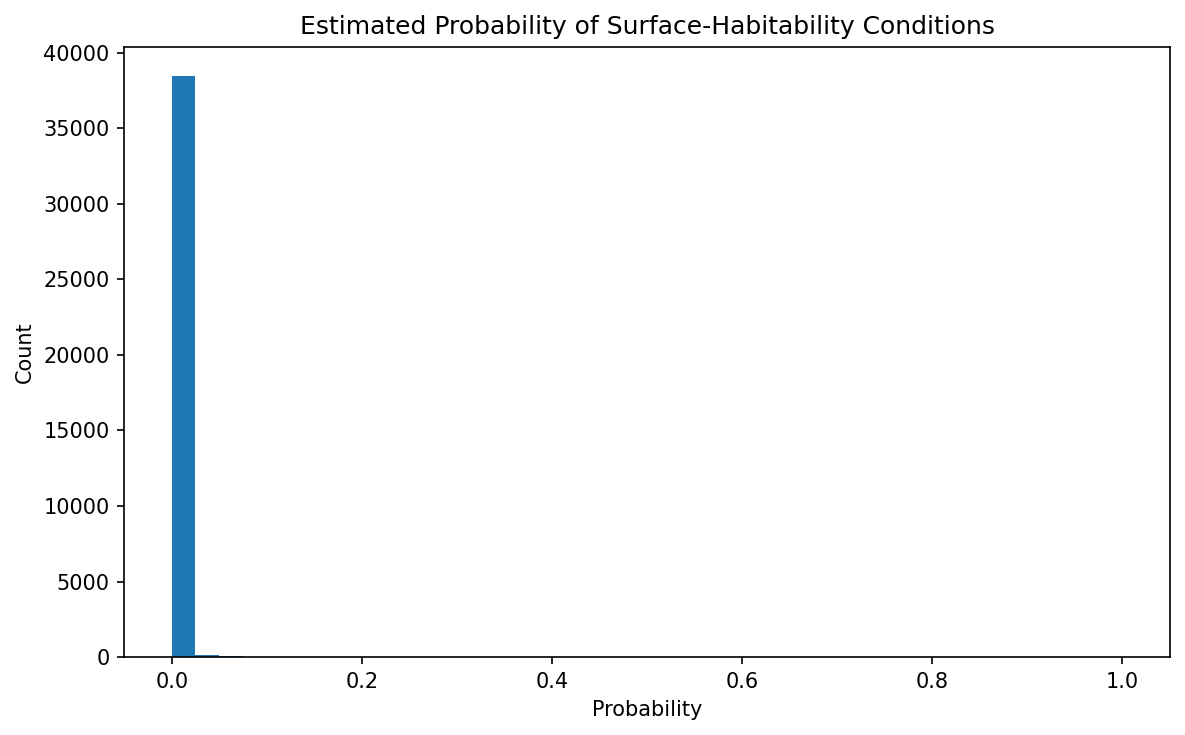

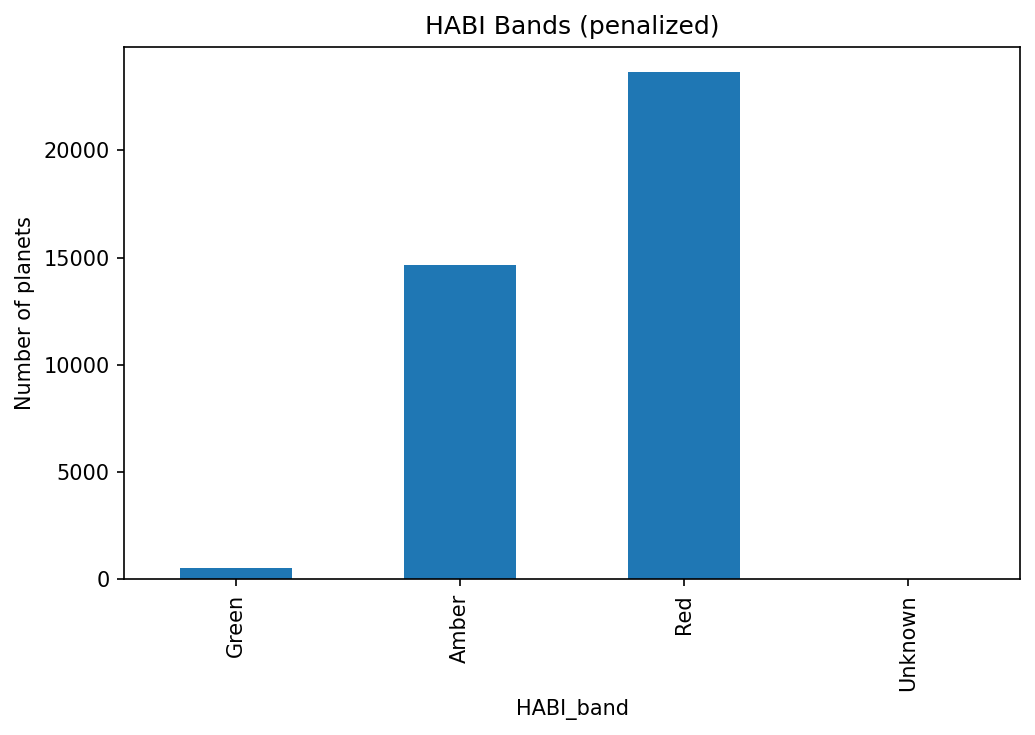

In [10]:

sun_ci = kopparapu_seff(5778, "RG_1ME"); sun_co = kopparapu_seff(5778, "MG")
mask = (~df["insolation_earth_units"].isna()) & (~df["st_teff"].isna())
plt.figure(figsize=(9,6))
plt.scatter(df.loc[mask,"st_teff"], df.loc[mask,"insolation_earth_units"], s=6, alpha=0.6)
plt.axhspan(min(sun_ci,sun_co), max(sun_ci,sun_co), alpha=0.15)
plt.yscale("log")
plt.title("Insolation vs Stellar Temperature (log) — HZ band (conservative, Sun)")
plt.xlabel("Stellar Effective Temperature (K)")
plt.ylabel("Insolation (Earth = 1)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
df["HABI_penalized_soft"].dropna().plot(kind="hist", bins=40)
plt.title("HABI (penalized by confidence)")
plt.xlabel("HABI")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
df["p_viable_final"].dropna().plot(kind="hist", bins=40)
plt.title("Estimated Probability of Surface-Habitability Conditions")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

def band(x):
    if pd.isna(x): return "Unknown"
    if x>=0.70: return "Green"
    if x>=0.50: return "Amber"
    return "Red"
df["HABI_band"] = df["HABI_penalized_soft"].apply(band)

plt.figure(figsize=(7,5))
df["HABI_band"].value_counts().reindex(["Green","Amber","Red","Unknown"]).plot(kind="bar")
plt.title("HABI Bands (penalized)")
plt.ylabel("Number of planets")
plt.tight_layout()
plt.show()


## 11) Stacked contributions, radar for top 3, and ablation

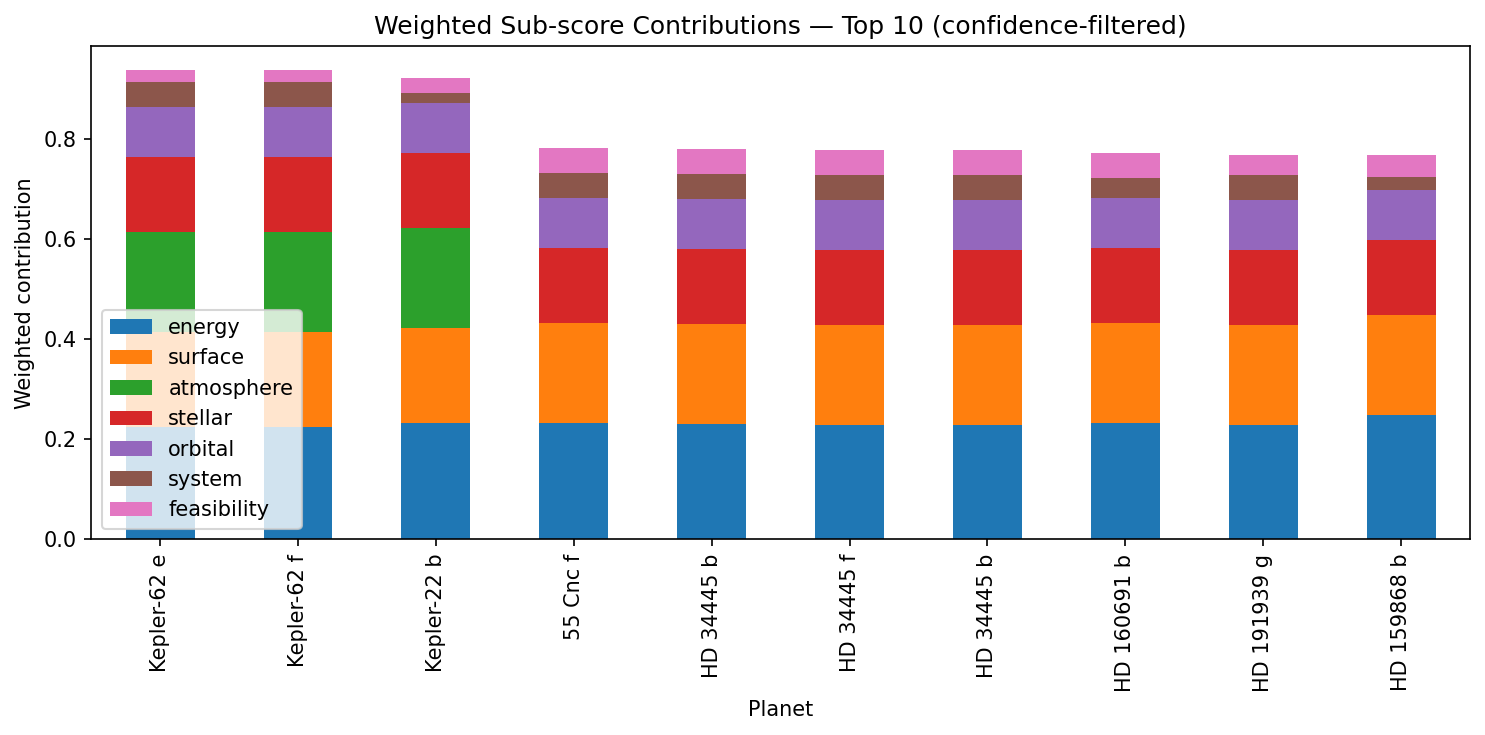

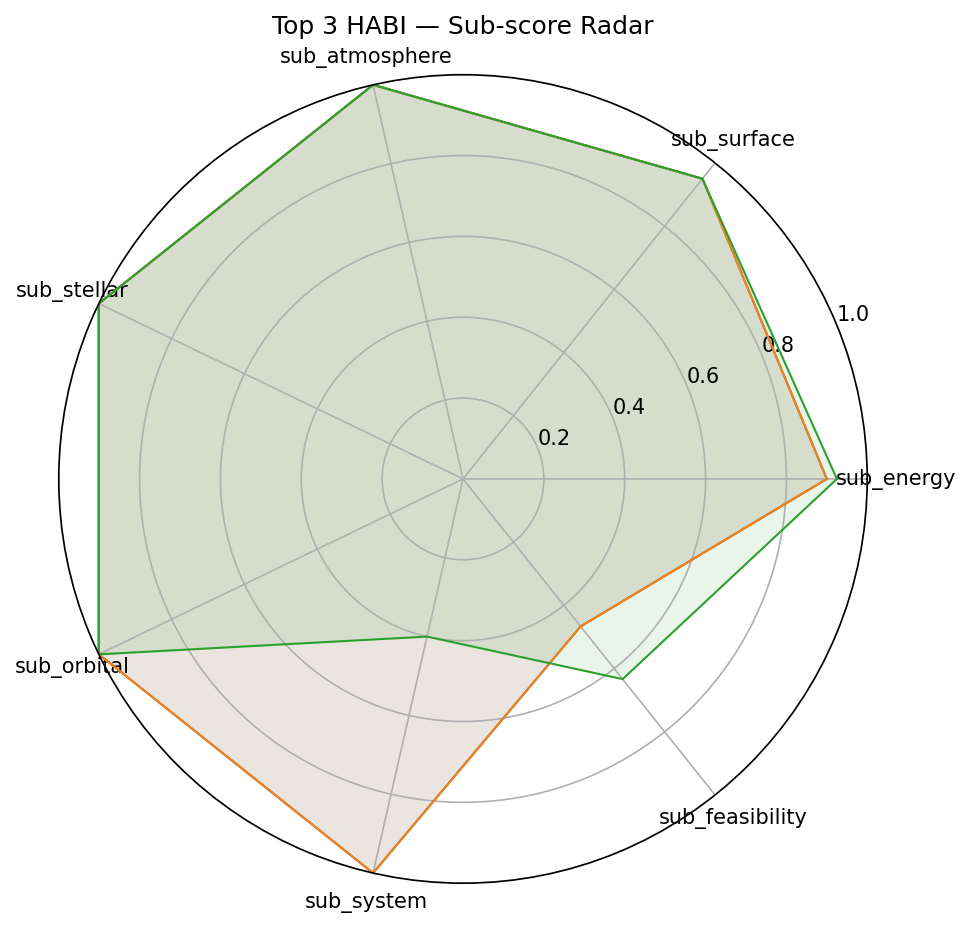

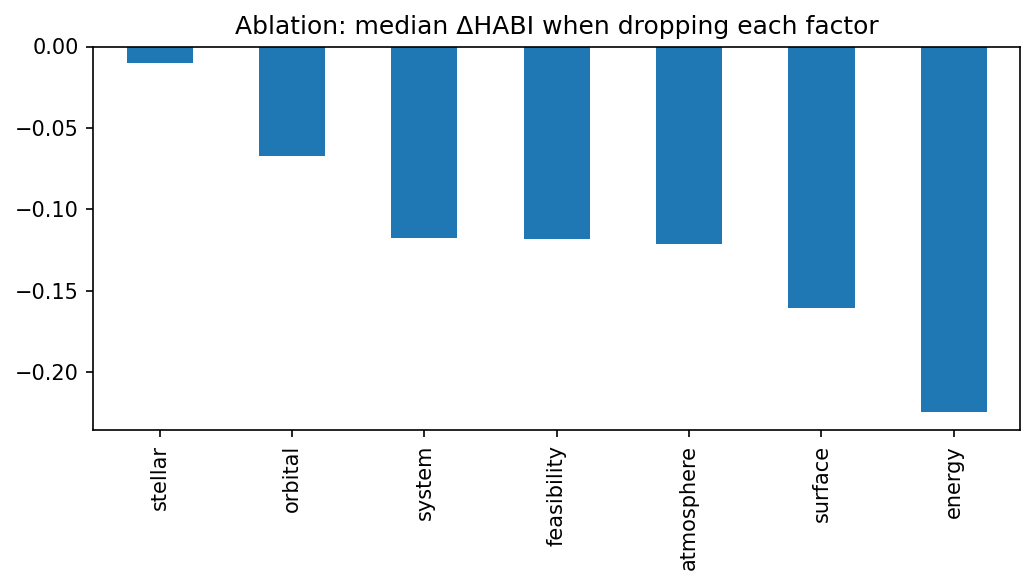

In [11]:

def contrib_row(row):
    return {k: (row.get(f"sub_{k}", np.nan) if not pd.isna(row.get(f"sub_{k}", np.nan)) else 0.0)*W[k]
            for k in W.keys()}

rank_mask = df["HABI_confidence"] >= 0.60
top10 = (df[rank_mask].dropna(subset=["HABI_penalized_soft"])
          .sort_values(["HABI_penalized_soft","HABI_confidence"], ascending=[False, False])
          .head(10))
import pandas as pd, matplotlib.pyplot as plt
contrib = pd.DataFrame([contrib_row(r) for _, r in top10.iterrows()], index=top10["pl_name"].tolist())
contrib.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Weighted Sub-score Contributions — Top 10 (confidence-filtered)")
plt.ylabel("Weighted contribution")
plt.xlabel("Planet")
plt.tight_layout()
plt.show()

def radar_plot(sub_df, names):
    import numpy as np, matplotlib.pyplot as plt
    labels = list(sub_df.columns)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    for i, row in enumerate(sub_df.values):
        vals = row.tolist(); vals += vals[:1]
        ax.plot(angles, vals, linewidth=1)
        ax.fill(angles, vals, alpha=0.1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title("Top 3 HABI — Sub-score Radar")
    ax.set_rlim(0,1)
    plt.show()

subcols = [f"sub_{k}" for k in W.keys()]
top3 = (df[rank_mask].dropna(subset=["HABI_penalized_soft"])
          .sort_values(["HABI_penalized_soft","HABI_confidence"], ascending=[False, False])
          .head(3))
if len(top3) == 3:
    radar_plot(top3[subcols], top3["pl_name"].tolist())

def recompute_habi_from_subs(row):
    num=den=0.0
    for k in W.keys():
        v = row.get(f"sub_{k}", np.nan)
        if not pd.isna(v):
            num += v*W[k]; den += W[k]
    return (num/den if den>0 else np.nan)

ablation = {}
base = df["HABI_penalized_soft"].copy()
for k in W.keys():
    tmp = df.copy()
    tmp[f"sub_{k}"] = np.nan
    tmp["HABI_drop_"+k] = tmp.apply(recompute_habi_from_subs, axis=1)
    ablation[k] = (base - tmp["HABI_drop_"+k]).median()

import pandas as pd
abl = pd.Series(ablation).sort_values(ascending=False)
plt.figure(figsize=(7,4))
abl.plot(kind="bar")
plt.title("Ablation: median ΔHABI when dropping each factor")
plt.tight_layout()
plt.show()


## 12) Exports (tables + model card)

In [14]:

cols_master = [
    "pl_name","hostname","discoverymethod","disc_year","ra","dec",
    "pl_rade","pl_bmasse","pl_orbper","pl_orbsmax","pl_orbeccen",
    "st_teff","st_rad","st_mass","st_met","sy_dist","sy_vmag","sy_gaiamag","sy_pnum",
    "st_lum","insolation_earth_units","Smin","Smax",
    "Seff_inner_conservative","Seff_outer_conservative","Seff_inner_optimistic","Seff_outer_optimistic",
    "is_hz_conservative","is_hz_optimistic","is_earthsized","earthlike_flag",
    "HABI_confidence","HABI_veto","HABI_veto_reason","HABI","HABI_hybrid","HABI_penalized_soft","HABI_band",
    "p_viable_mc","p_mc_method","p_viable_habi","p_viable_final",
] + [f"sub_{k}" for k in ["energy","surface","atmosphere","stellar","orbital","system","feasibility"]]

df[cols_master].to_csv("habi_scores_v2.csv", index=False)
print("Wrote:", "habi_scores_v2.csv")

rank_mask = df["HABI_confidence"] >= 0.60
topH = (df[rank_mask].dropna(subset=["HABI_penalized_soft"])
        .sort_values(["HABI_penalized_soft","HABI_confidence"], ascending=[False, False])
        .head(25))[cols_master]
topH.to_csv("top_habi_v2.csv", index=False)
print("Wrote:", "top_habi_v2.csv")

topP = (df.dropna(subset=["p_viable_final"])
          .sort_values(["p_viable_final","HABI_penalized_soft"], ascending=[False, False])
          .head(25))[cols_master]
topP.to_csv("top_probability_v2.csv", index=False)
print("Wrote:", "top_probability_v2.csv")

df[df["inside_hz_high"]].sort_values("HABI_penalized_soft", ascending=False)[cols_master].to_csv("inside_hz_highscore_v2.csv", index=False)
df[df["outside_hz_high"]].sort_values("HABI_penalized_soft", ascending=False)[cols_master].to_csv("outside_hz_highscore_v2.csv", index=False)
print("Wrote:", "inside_hz_highscore_v2.csv", "outside_hz_highscore_v2.csv")

model_card = '''
HABI v2 Model Card
-------------------
Purpose: rank exoplanets by surface-habitability potential and estimate probability under uncertainty.
(See notebook header for details)
'''
with open("MODEL_CARD_HABI_v2.txt", "w", encoding="utf-8") as f:
    f.write(model_card)
print("Wrote:", "MODEL_CARD_HABI_v2.txt")

print("\\nDONE ✅")


Wrote: habi_scores_v2.csv
Wrote: top_habi_v2.csv
Wrote: top_probability_v2.csv
Wrote: inside_hz_highscore_v2.csv outside_hz_highscore_v2.csv
Wrote: MODEL_CARD_HABI_v2.txt
\nDONE ✅
